In [2]:
import regex as re
import numpy as np
from statistics import mean, stdev
import matplotlib.pyplot as plt
from bento_bench import bar_plot, parse_elapsed_secs, get_avg_from_table_str
import pandas as pd
import seaborn as sns
fsl = ["Bento-fs", "Bento-user", "Bento-prov", "ext4-ordered", "ext4-journal"]
tl = [1, 18]
ops_workloads = ["createfiles_1t.f", "deletefiles_1t.f", "fileserver.f", "varmail.f", "webserver.f"]
fb_ops_regex = "\d*.\d*(?=\sops\/s)"
fb_mbs_regex = "(?<=rd\/wr\s*)\d*.\d*(?=mb\/s)"

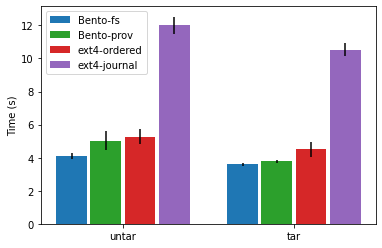

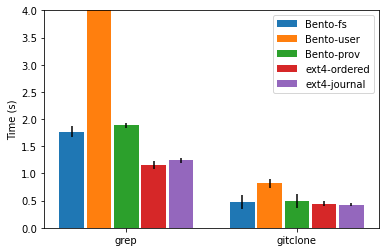

In [3]:
otherapps_1 = ["untar", "tar"]
otherapps_2 = ["grep", "gitclone"]
otherapps_1_avg = {}
otherapps_1_std = {}
otherapps_2_avg = {}
otherapps_2_std = {}
fsl_tar = ["Bento-fs", "Bento-prov", "ext4-ordered", "ext4-journal"]
for fs in fsl:
	otherapps_2_avg[fs] = []
	otherapps_2_std[fs] = []
	for app in otherapps_2:
		tmp = []
		dir = "./results/" + fs + "/" + app
		for f in os.listdir(dir):
			i = int(f.split("_")[1])
			fr = open(dir + "/" + f, 'r')
			t = fr.read()
			fr.close()
			matches = re.findall("\d*:\d*.\d*(?=elapsed)", t)
			tmp.append(parse_elapsed_secs(matches[0]))
		otherapps_2_avg[fs].append(mean(tmp))
		otherapps_2_std[fs].append(stdev(tmp))

	if fs == "Bento-user": continue # Bento-user tar is broken

	otherapps_1_avg[fs] = []
	otherapps_1_std[fs] = []
	for app in otherapps_1:
		tmp = []
		dir = "./results/" + fs + "/" + app
		for f in os.listdir(dir):
			i = int(f.split("_")[1])
			fr = open(dir + "/" + f, 'r')
			t = fr.read()
			fr.close()
			matches = re.findall("\d*:\d*.\d*(?=elapsed)", t)
			tmp.append(parse_elapsed_secs(matches[0]))
		otherapps_1_avg[fs].append(mean(tmp))
		otherapps_1_std[fs].append(stdev(tmp))

fig, ax = plt.subplots()
bar_plot(ax, otherapps_1_avg, fsl_tar, yerr=otherapps_1_std, colors=['#1f77b4', '#2ca02c', '#d62728', '#9467bd'], total_width=.8, single_width=.9)
plt.xticks(range(len(otherapps_1)), otherapps_1)
plt.ylabel("Time (s)")
plt.savefig("./plots/untartar.png")

fig, ax = plt.subplots()
bar_plot(ax, otherapps_2_avg, fsl, yerr=otherapps_2_std, total_width=.8, single_width=.9)
plt.xticks(range(len(otherapps_2)), otherapps_2)
plt.ylim(0, 4)
plt.ylabel("Time (s)")
plt.savefig("./plots/grepgitclone.png")

{'Bento-fs': [0.9926589909886193, 1.1546876584006456], 'Bento-user': [0.1588775868777594, 2.472330903364149], 'Bento-prov': [0.2474608663110865, 0.24133819897776937], 'ext4-ordered': [1.9731891647964215, 1.7608300178595575], 'ext4-journal': [2.507691171117537, 1.5378094568665048]}


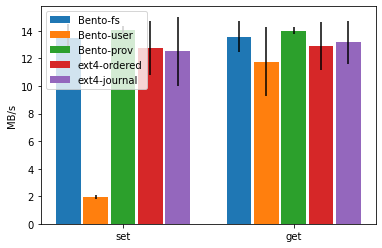

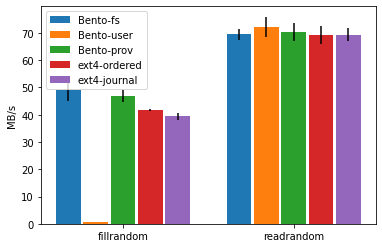

In [4]:
redis = ["set", "get"]
rocksdb = ["fillrandom", "readrandom"]
redis_avg = {}
redis_std = {}
rocksdb_avg = {}
rocksdb_std = {}

for fs in fsl:
	redis_avg[fs] = []
	redis_std[fs] = []
	tmp_set = []
	tmp_get = []
	dir = "./results/" + fs + "/redis"
	for f in os.listdir(dir):
		i = int(f.split("_")[1])
		fr = open(dir + "/" + f, 'r')
		t = fr.read()
		fr.close()
		matches = re.findall("\d*.\d*(?= requests per second)", t)
		tmp_set.append(float(matches[0]) * 0.0001) # convert
		tmp_get.append(float(matches[1]) * 0.0001) # convert
	redis_avg[fs].append(mean(tmp_set))
	redis_std[fs].append(stdev(tmp_set))
	redis_avg[fs].append(mean(tmp_get))
	redis_std[fs].append(stdev(tmp_get))

	rocksdb_avg[fs] = []
	rocksdb_std[fs] = []
	tmp_fillrandom = []
	tmp_readrandom = []
	dir = "./results/" + fs + "/rocksdb"
	for f in os.listdir(dir):
		i = int(f.split("_")[1])
		fr = open(dir + "/" + f, 'r')
		t = fr.read()
		fr.close()
		matches = re.findall("\d*.\d*(?= MB/s)", t)
		tmp_fillrandom.append(float(matches[0]))
		tmp_readrandom.append(float(matches[1]))
	rocksdb_avg[fs].append(mean(tmp_fillrandom))
	rocksdb_std[fs].append(stdev(tmp_fillrandom))
	rocksdb_avg[fs].append(mean(tmp_readrandom))
	rocksdb_std[fs].append(stdev(tmp_readrandom))

print(redis_std)

fig, ax = plt.subplots()
#bax = brokenaxes(ylims=((0, 10), (25, 50), (150, 170)), hspace=.1)
bar_plot(ax, redis_avg, fsl, yerr=redis_std, total_width=.8, single_width=.9)
plt.xticks(range(len(redis)), redis)
plt.ylabel("MB/s")
plt.savefig("./plots/redis.png")

fig, ax = plt.subplots()
bar_plot(ax, rocksdb_avg, fsl, yerr=rocksdb_std, total_width=.8, single_width=.9)
plt.xticks(range(len(rocksdb)), rocksdb)
plt.ylabel("MB/s")
plt.savefig("./plots/rocksdb.png")

In [13]:
fbresults = pd.DataFrame(columns=["fs", "workload", "T", "i", "r"])
for fs in fsl:
	fbfsresdir = "./results/" + fs + "/filebench/"
	for f in os.listdir(fbfsresdir):
		fresdir = fbfsresdir + f
		for r in os.listdir(fresdir):
			rfile = open(fresdir + "/" + r)
			rtext = rfile.read()
			rfile.close()

			regex = ""
			if f in ops_workloads:
				regex = fb_ops_regex
			else:
				regex = fb_mbs_regex

			matches = re.findall(regex, rtext)

			T = ""
			if "1t" in f:
				(T, i) = r.split("_")
			else:
				i = r

			fbresults = fbresults.append({"fs": fs,
						       "workload": f.replace("_1t", ""),
						       "T": T,
						       "i": i,
						       "r": float(matches[0])},
						      ignore_index=True)

fbavg_cols = ["Workload"]
for fs in fsl:
	fbavg_cols.append(fs)

fbavg = pd.DataFrame(columns=fbavg_cols)
for w in fbresults["workload"].unique():
	d = fbresults[fbresults["workload"] == w]
	w = w.split(".")[0] # remove the file extension
	for T in d["T"].unique():
		d1 = d[d["T"] == T]
		wT = w
		if T != "":
			wT += ", T=" + T

		row = { "Workload": wT }
		for fs in fsl:
			d2 = d1[d1["fs"] == fs]
			r = str(round(d2["r"].mean(), 2))
			if len(d2) > 1:
				r += " (" + str(round(d2["r"].std(), 2)) + ")"
			row[fs] = r
		fbavg = fbavg.append(row, ignore_index=True)

for i, row in fbavg.iterrows():
	fbavg.loc[i, "Bento-fs:ext4-j"] = get_avg_from_table_str(row["Bento-fs"]) / get_avg_from_table_str(row["ext4-journal"])

sort_dict = {
	"seq_read_4k, T=1": 0, "seq_read_32k, T=1": 1,"seq_read_128k, T=1": 2,"seq_read_1024k, T=1": 3,
	"seq_read_4k, T=18": 4, "seq_read_32k, T=18": 5,"seq_read_128k, T=18": 6,"seq_read_1024k, T=18": 7,
	"rand_read_4k, T=1": 8, "rand_read_32k, T=1": 9,"rand_read_128k, T=1": 10,"rand_read_1024k, T=1": 11,
	"rand_read_4k, T=18": 12, "rand_read_32k, T=18": 13,"rand_read_128k, T=18": 14 ,"rand_read_1024k, T=18": 15,
	"seq_write_4k, T=1": 16, "seq_write_32k, T=1": 17,  "seq_write_128k, T=1": 18, "seq_write_1024k, T=1": 19,
	"seq_write_4k, T=18": 20, "seq_write_32k, T=18": 21,"seq_write_128k, T=18": 22,"seq_write_1024k, T=18": 23,
	"rand_write_4k, T=1": 24, "rand_write_32k, T=1": 25,"rand_write_128k, T=1": 26,"rand_write_1024k, T=1": 27,
	"rand_write_4k, T=18": 28, "rand_write_32k, T=18": 29,"rand_write_128k, T=18": 30 ,"rand_write_1024k, T=18": 31,
	"createfiles, T=1": 32, "createfiles, T=18": 33, "deletefiles, T=1": 34, "deletefiles, T=18": 35}
fbavg = fbavg.sort_values(by="Workload", key=lambda x: x.map(sort_dict))

filebench_file = open("./tables/filebench.txt", "w")
filebench_file.write(fbavg[:-3].to_latex(index=False))
filebench_file.close()

221220.68 (2297.69)


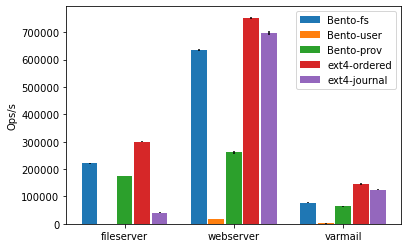

In [6]:
app_workloads = [ "fileserver", "webserver", "varmail" ]
app_workloads_avg = {}
app_workloads_std = {}
print(fbavg[fbavg["Workload"] == "fileserver"].iloc[0]["Bento-fs"])
for fs in fsl:
	app_workloads_avg[fs] = []
	app_workloads_std[fs] = []
	for aw in app_workloads:
		app_workloads_avg[fs].append(float(fbavg[fbavg["Workload"] == aw].iloc[0][fs].split(" (")[0]))
		app_workloads_std[fs].append(float(fbavg[fbavg["Workload"] == aw].iloc[0][fs].split(" (")[1].split(")")[0]))

fig, ax = plt.subplots()
bar_plot(ax, app_workloads_avg, fsl, yerr=app_workloads_std, total_width=.8, single_width=.9)
plt.xticks(range(len(app_workloads)), app_workloads)
plt.ylabel("Ops/s")
plt.savefig("./plots/app_workloads.png")